In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ENDERECO_DADOS = "https://www.ispdados.rj.gov.br/Arquivos/BaseDPEvolucaoMensalCisp.csv"

try:
    df_ocorrencias = pd.read_csv(ENDERECO_DADOS, sep=";", encoding="iso-8859-1")
    # print(df_ocorrencias())

    df_ocorrencias = df_ocorrencias[['cisp', 'roubo_veiculo', 'recuperacao_veiculos']]
    print(df_ocorrencias)

    df_total_roubos = df_ocorrencias.groupby(['cisp']).sum(['roubo_veiculo', 'recuperacao_veiculos']).reset_index()
except Exception as e:
    print(f"Erro ao conectar ao banco de dados:{e} ")

       cisp  roubo_veiculo  recuperacao_veiculos
0         1              5                     5
1         4              9                     7
2         5             11                    10
3         6             27                    77
4         7             23                     9
...     ...            ...                   ...
36350   159              1                     3
36351   165              0                     1
36352   166              0                     2
36353   167              0                     4
36354   168              0                     1

[36355 rows x 3 columns]


In [2]:
#   Delimitando as variaveis

try:
    df_veiculos = df_ocorrencias[['cisp', 'roubo_veiculo', 'recuperacao_veiculos']]
#   Selecionando as variaveis
    df_total_veiculos = df_veiculos.groupby(['cisp']).sum(['roubo_veiculo', 'recuperacao_veiculos']).reset_index()
    # print(df_total_veiculos.head(10))
except Exception as e:
    print(f"Erro ao processar dados:{e} ")

In [3]:
#   Calculando a Correlação
try:
    df_total_cut = (
        df_total_veiculos[
            df_total_veiculos['roubo_veiculo'] < np.percentile(df_total_veiculos['roubo_veiculo'], 95)
            ]
    )

    df_total_veiculos_cut = (
        df_total_veiculos[
            df_total_veiculos['recuperacao_veiculos'] < np.percentile(df_total_veiculos['recuperacao_veiculos'], 99)
        ]
    )    

#   Arrays
    array_roubo_veiculo = np.array(df_total_veiculos_cut['roubo_veiculo'])
    array_recuperacao_veiculos = np.array(df_total_veiculos_cut['recuperacao_veiculos'])

#   Calculando a correlação
    correlacao = np.corrcoef(array_roubo_veiculo, array_recuperacao_veiculos)[0,1]
    
    print(f'correlacao: {correlacao:.2f}')


except Exception as e:
    print(f"Erro ao processar dados:{e}")
    exit()

correlacao: 0.92


In [4]:
#   Aplicando o modelo de regressão linear
try:
    print('\nIniciando a regressão linear... ')
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        array_roubo_veiculo, #  Variavel independente
        array_recuperacao_veiculos, # Variável dependente
        test_size=0.2,   # 20% dos dados serão usados para teste e 80% para treino
        random_state=42 # Seed para reprodutibilidade
    )
   
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train.reshape(-1, 1))

    X_test = scaler.transform(X_test.reshape(-1, 1))

    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X_train, y_train)

    r2_score = model.score(X_test, y_test)
    print(f'\nCoeficiente de determinação (R²): {r2_score:.2f}')
    print(f'Coeficiente angular: {model.coef_[0]:.2f}')
    print(f'Coeficiente linear: {model.intercept_:.2f}')




except Exception as e:
    print(f"Erro ao processar dados:{e}")



Iniciando a regressão linear... 

Coeficiente de determinação (R²): 0.81
Coeficiente angular: 4361.42
Coeficiente linear: 3112.73


In [5]:
#   Previsão

try:
    print('\nIniciando a previsão... ')
    #   Array de previsão 35000, 43000, 58000
    array_roubo_veiculo_pred = np.array([35000, 43000, 58000])
    #   Normalizando os dados de entrada
    array_roubo_veiculo_pred_scaled = scaler.transform(array_roubo_veiculo_pred.reshape(-1, 1))
    #   Fazendo a previsão
    recup_pred = model.predict(array_roubo_veiculo_pred_scaled)
    print(f'\nPrevisão de recuperação de veículos : {recup_pred}')
except Exception as e:
    print(f"Erro ao processar dados:{e}")


Iniciando a previsão... 

Previsão de recuperação de veículos : [22843.25828419 27962.65770392 37561.53161591]


Avaliando o modelo de previsões...


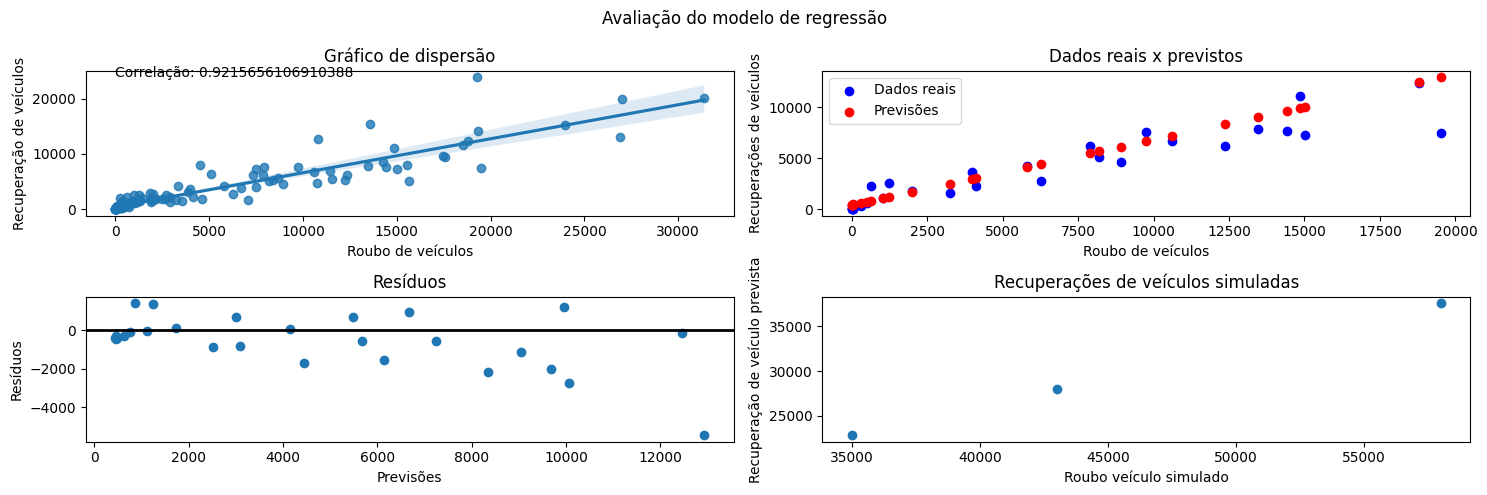

In [6]:
# AVALIANDO O MODELO

# P/ Rodar a Tkinter p/ plotar o painel como no Jupyter

try:
    print('Avaliando o modelo de previsões...')

    plt.subplots(2, 2, figsize=(15, 5))
    plt.suptitle('Avaliação do modelo de regressão')


    #### POSIÇÃO 1: Gráfico de Dispersão entre os arrays
    # pip install seaborn
    plt.subplot(2, 2, 1)

    sns.regplot(x=array_roubo_veiculo, y=array_recuperacao_veiculos)
    plt.title('Gráfico de dispersão')
    plt.xlabel('Roubo de veículos')
    plt.ylabel('Recuperação de veículos')

    # Posicionar o texto no início do gráfico
    plt.text(min(array_roubo_veiculo),
             max(array_recuperacao_veiculos),
             f'Correlação: {correlacao}',
             fontsize=10)


    #### POSIÇÃO 2: Gráfico de dispersão entre os dados reais e previsto
    plt.subplot(2, 2, 2)

    # Testar o modelo preditivo nos dados de X_teste
    # Saída na escal original dos dados
    y_pred = model.predict(X_test)

    # Retornar os dados de teste para escala real
    X_test = scaler.inverse_transform(X_test)

    # Gráfico de dispersão sem a linha de regressão
    plt.scatter(X_test, y_test, color='blue', label='Dados reais')
    plt.scatter(X_test, y_pred, color = 'red', label='Previsões')

    plt.title('Dados reais x previstos')
    plt.xlabel('Roubo de veículos')
    plt.ylabel('Recuperações de veículos')

    plt.legend()


    ##### POSIÇÃO 3: Resíduos
    plt.subplot(2, 2, 3)

    # RESÍDUOS: Diferença entre valores reais e previstos (y_test - y_pred)
    # Análise dos resíduos ajuda a verificar, se o modelo está capturando bem
    # os padrões dos dados. 
    # Bons modelos têm resíduos próximos de 0.
    # Os dados devem ser distribuídos aleatoriamente.
    # Se tiverem um padrão, o modelo não é confiável
    residuos = y_test - y_pred

    # plotar em gráfico de dispersão
    plt.scatter(y_pred, residuos)

    # adicioanar uma linha constante no 0
    plt.axhline(y=0, color='black', linewidth=2)

    plt.title('Resíduos')
    plt.xlabel('Previsões')
    plt.ylabel('Resíduos')


    #### POSIÇÃO 4: Dispersão dos valores simulados
    plt.subplot(2, 2, 4)
    
    plt.scatter(array_roubo_veiculo_pred, recup_pred)

    plt.title('Recuperações de veículos simuladas')
    plt.xlabel('Roubo veículo simulado')
    plt.ylabel('Recuperação de veículo prevista')

    plt.tight_layout()
    plt.show()

except ImportError as e:
    print("Erro ao avaliar o modelo: ", e)
    exit()